In [1]:
from sklearn.datasets import fetch_20newsgroups
groups = fetch_20newsgroups()

In [2]:
data_train = fetch_20newsgroups(subset='train', random_state=21)
train_label = data_train.target
data_test = fetch_20newsgroups(subset='test', random_state=21)
test_label = data_test.target
len(data_train.data), len(data_test.data), len(test_label)

(11314, 7532, 7532)

Il y a 20 classes différentes :

In [3]:
import numpy as np
np.unique(test_label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

## **Nettoyage du corpus et réduction du bruit dans ce dernier**

On filtre les éléments dans le corpus avec 2 conditions :

#### **1. Suppression des entités nommées**

Les prénoms peuvent introduire du bruit et biaiser l'apprentissage du modèle. Pour retirer les prénoms, on utilise le corpus NLTK qui contient de très nombreux noms en anglais. Ensuite on retire les noms dans la boucle, en utilisant `words not in all_names`.

#### **2. Suppression des caractères spéciaux**

On élimine la ponctuation (ex: "!", "?", ".") et les nombres avec `words.isalpha()`.


#### **Normalisation et lemmatisation**

Si un mot satisfait ces deux conditions, on applique `words.lower()` qui transforme le mot en minuscules et on réduit le mot à sa forme de base (lemme) avec `WNL.lemmatize(...)` . Cela réduit la dimensionalité du vocabulaire

In [4]:
import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('names')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


True

In [5]:
import re
from multiprocessing import Pool, cpu_count
from functools import partial

def init_worker():
    global names_set, wnl
    from nltk.corpus import names
    from nltk.stem import WordNetLemmatizer
    names_set = {n.lower() for n in names.words()}
    wnl = WordNetLemmatizer()

def clean_text(text):
    global names_set, wnl
    # Regex
    tokens = re.findall(r'[a-z]{3,}', text.lower())
    words = [wnl.lemmatize(w) for w in tokens if w not in names_set]
    return " ".join(words)

def clean(data):
    with Pool(cpu_count(), initializer=init_worker) as pool:
        return pool.map(clean_text, data, chunksize=100)

In [6]:
x_test = clean(data_test.data)
x_train = clean(data_train.data)
len(x_test)
len(x_train)

11314

# **SVM linéaire**


On distingue deux grands types de SVM linéaires : le **Hard margin** SVM et le **Soft margin** SVM.

### SVM **Hard Margin**

Dans le premier, les instances doivent être parfaitement séparables par un hyperplan linéaire.

Pour les points $x_i$ dans la classe $y_i = 1$ on impose :
$$\omega^\top x_i + b \ge 1$$

Pour les points $x_i$ dans la classe $y_i = -1$ on impose :
$$\omega^\top x_i + b \le -1$$

On constate qu'un élément $x_i$ est bien classifié si $y_i$ et $(\omega^\top x_i + b)$ ont le même signe. Ainsi, on peut reformuler ces deux contraintes de manière unifiée :
$$\boxed{\forall i,\quad y_i \cdot (\omega^\top x_i + b) \ge 1}$$


Mais cela suppose que les données soient parfaitement linéairement séparables.

Si ce n'est pas le cas, alors, quel que soit l’hyperplan choisi, il existera au moins un point $x_i$ pour lequel $y_i \cdot (\omega^\top x_i + b) \le 0$ c’est-à-dire au moins un point mal classé (ce qui arrive si $y_i$ et $(\omega^\top x_i + b)$ ont des signes différents), ou situé sur la frontière de décision (ce qui arrive si $y_i \cdot (\omega^\top x_i + b) = 0$).

Formellement, c'est linéairement séparable si

$$\exists (\omega,b)\ \text{tel que}\ \forall i,\ y_i(\omega^\top x_i + b) > 0$$


et non linéairement séparable si :

$$\forall (\omega,b),\ \exists i\ \text{tel que}\ y_i(\omega^\top x_i + b) \le 0$$

### SVM **Soft Margin**

C'est ce pourquoi on utilise un **SVM linéaire soft margin** qui fonctionne même si les données ne sont pas parfaitement linéairement séparables en tolérant des écarts et donc des erreurs de classifications éventuelles.

De manière générale, dans un SVM, il faut maximiser l'espacement entre les deux marges (qui correspondent aux deux hyperplans $\{ x \in \mathbb{R}^d \;|\; \omega^\top x + b = 1 \}$ et $\{ x \in \mathbb{R}^d \;|\; \omega^\top x + b = -1 \}$). Mais, avec certaines données non linéairement séparables, il faut trouver un compromis entre la largeur de la marge et les erreurs de classification.

Dans un SVM soft margin, on associe à chaque point $x_i$ une quantité $\xi_i$ qui indique “de combien il manque” pour satisfaire la condition idéale $y_i(\omega^\top x_i + b) \ge 1$. Pour chaque point $x_i$, la quantité $\xi_i$ est donnée par :

$$\xi_i = \max(0, 1 - y_i (\omega^\top x_i + b))$$

Il y a trois cas possibles (bien classé, dans la marge, mal classé) :

* Si le point $x_i$ est bien classé :

$$
y_i (\omega^\top x_i + b) \ge 1
\quad\Rightarrow\quad
\big[1 - y_i (\omega^\top x_i + b)\big] \le 0
\quad\Rightarrow\quad
\xi_i = 0
$$

* Si le point $x_i$ est dans la marge (entre les deux hyperplans) mais correctement classé :

$$
0 < y_i (\omega^\top x_i + b) < 1
\quad\Rightarrow\quad
0 < \xi_i = \big[1 - y_i (\omega^\top x_i + b)\big] < 1
$$

* Si le point $x_i$ est mal classé :

$$
y_i (\omega^\top x_i + b) < 0
\quad\Rightarrow\quad
\xi_i = \big[1 - y_i (\omega^\top x_i + b)\big] > 1
$$

Maintenant, on peut pénaliser le modèle à la fois en fonction du nombre de points du mauvais côté (en comptant à la fois les points dans les marges bien classés et ceux qui sont mal classés) et de l'ampleur des violations (plus la position d'un point s'écarte de sa position attendue, plus la pénalité sur la loss sera forte).

### **Comparaison de [`LinearSVC`]( https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) et de [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)**

Dans `LinearSVC` de Scikitlearn, on peut régler le compromis entre la largeur de la marge et les erreurs sur l’échantillon grâce à l'hyperparamètre $C$.

Si $C$ est grand, on cherche à réduire au maximum ces erreurs quitte à avoir une marge plus petite ; si $C$ est petit, on tolère davantage les violations pour favoriser une marge plus large.

Sur `SGDClassifier` l'hyperparamètre "alpha" joue un rôle équivalent

SGDClassifier avec loss='hinge' = SVM linéaire



## **Le choix de l'optimiseur d'hyperparamètres : GridSearch ou Optuna ?**


### **GridSearch**
**[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)** effectue une recherche ***exhaustive*** : il teste *toutes* les combinaisons possibles dans des grilles d'hyperparamètres prédéfinies.
Bien qu'on ait la garantie de trouver l'optimum global dans l'espace discret prédéfini, le temps et le coût computationnel peuvent vite devenir très élevés en fonction de la taille de l'espace des valeurs possibles.


### **Optuna**
**[`Optuna`](https://pypi.org/project/optuna/)** utilise une recherche ***bayésienne*** (algorithme TPE - Tree-structured Parzen Estimator) en échantillonnant l'espace des hyperparamètres et en privilégiant les régions prometteuses identifiées par les évaluations précédentes. Cela permet d'obtenir de bonnes solutions avec moins d'itérations. C'est pas absolument nécessaire ici mais dans certains cas où les espaces d'hyperparamètres à tester sont de très grande dimension et continus c'est plus rapide et efficace.


#### **Suppression des stop-words**

Scikit-learn possède un fichier interne qui contient une liste fixe de mots anglais considérés comme des `stop_words` . Comme ils le font dans les codes proposé sur leur site (par exemple [ce code](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html) ou encore [ce code](https://scikit-learn.org/0.21/auto_examples/text/plot_document_classification_20newsgroups.html)), on enlève les `stop_words` présents dans le corpus. On peut afficher le nombre de ces `stop_words` et les inspecter manuellement avec :

```python
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print(len(ENGLISH_STOP_WORDS))
print(list(ENGLISH_STOP_WORDS))
```

# Méthodologie

Puisqu'on ne sait pas trop quoi choisir entre [`LinearSVC`]( https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) et  [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), nous allons tester une optimisation des hyperparamètres avec les deux

Pour que ce soit vraiment comparable, on va essayer de faire vraiment l'équivalent des deux côtés.

Commençons par computer toutes les matrices TF-IDF qui vont être utilisées, de manière à éviter de les re-calculer. La cellule qui suit prend quelques minutes à s'executer et prend un certain espace dans la RAM, mais elle permettra de gagner du temps lors des étapes qui suivent.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import Parallel, delayed
from itertools import product
import numpy as np

# Valeurs discrètes pour le cache (step=4000 pour max_features)
MAX_FEATURES_VALUES = [10000, 15000, 20000, 25000, 30000]
MAX_DF_VALUES = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

def precompute_tfidf(texts_train, texts_test, max_feats, max_df_vals, n_jobs=-1):
    """
    Pré-calcule les matrices TF-IDF pour toutes les combinaisons d'hyperparamètres.
    Stocke aussi le vectorizer pour transformer les données de test.
    """
    def fit(mf, mdf):
        vec = TfidfVectorizer(
            stop_words="english",
            ngram_range=(1, 2),
            max_features=mf,
            max_df=mdf,
            dtype=np.float32
        )
        X_train = vec.fit_transform(texts_train)
        X_test = vec.transform(texts_test)
        return (mf, mdf), {
            'vectorizer': vec,
            'X_train': X_train,
            'X_test': X_test
        }

    results = Parallel(n_jobs=n_jobs)(
        delayed(fit)(mf, mdf)
        for mf, mdf in product(max_feats, max_df_vals)
    )
    return dict(results)

# Pré-calcul (exécuté une seule fois)
print(f"Pré-calcul de {len(MAX_FEATURES_VALUES) * len(MAX_DF_VALUES)} matrices TF-IDF...")
tfidf_cache = precompute_tfidf(
    x_train, x_test,
    MAX_FEATURES_VALUES,
    MAX_DF_VALUES
)
print(f"Cache créé avec {len(tfidf_cache)} entrées.")

Pré-calcul de 30 matrices TF-IDF...
Cache créé avec 30 entrées.


In [8]:
pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.5 MB/s eta 0:00:00


In [9]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
import optuna
import time

def create_objective_fast_cached(y, tfidf_cache, cv=3):
    """Objective utilisant le cache TF-IDF pré-calculé."""
    def objective(trial):
        # Utiliser suggest_categorical pour correspondre exactement au cache
        max_features = trial.suggest_categorical('max_features', MAX_FEATURES_VALUES)
        max_df = trial.suggest_categorical('max_df', MAX_DF_VALUES)
        alpha = trial.suggest_float('alpha', 1e-4, 1e-2, log=True)

        # Récupération de la matrice pré-calculée (économie de compute !)
        X_tfidf = tfidf_cache[(max_features, max_df)]['X_train']

        clf = SGDClassifier(
            loss='hinge',
            alpha=alpha,
            max_iter=1000,
            tol=1e-3,
            random_state=42
        )

        # Mesure du temps d'exécution
        t0 = time.perf_counter()
        score = cross_val_score(clf, X_tfidf, y, cv=cv, n_jobs=-1).mean()
        trial.set_user_attr("duration", time.perf_counter() - t0)

        return score

    return objective

def run_optuna_fast_cached(y, tfidf_cache, n_trials=30, cv=3):
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
    )
    objective = create_objective_fast_cached(y, tfidf_cache, cv)
    study.optimize(objective, n_trials=n_trials, n_jobs=1, show_progress_bar=True)
    return study

# Lancement
study_sgd = run_optuna_fast_cached(train_label, tfidf_cache, n_trials=30)

print(f"\n[SGDClassifier] Meilleurs paramètres : {study_sgd.best_params}")
print(f"[SGDClassifier] Meilleur score CV : {study_sgd.best_value:.4f}")

[I 2025-12-13 15:32:36,625] A new study created in memory with name: no-name-99f21844-2c68-4cfd-b7d5-00b0e4d4ce6f


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-13 15:32:38,162] Trial 0 finished with value: 0.8633557580084812 and parameters: {'max_features': 15000, 'max_df': 0.7, 'alpha': 0.008706020878304856}. Best is trial 0 with value: 0.8633557580084812.
[I 2025-12-13 15:32:39,880] Trial 1 finished with value: 0.868835897552708 and parameters: {'max_features': 10000, 'max_df': 0.8, 'alpha': 0.0005404103854647331}. Best is trial 1 with value: 0.868835897552708.
[I 2025-12-13 15:32:41,355] Trial 2 finished with value: 0.8634441518916245 and parameters: {'max_features': 15000, 'max_df': 1.0, 'alpha': 0.004138040112561018}. Best is trial 1 with value: 0.868835897552708.
[I 2025-12-13 15:32:44,123] Trial 3 finished with value: 0.8710453228153048 and parameters: {'max_features': 20000, 'max_df': 0.7, 'alpha': 0.001096821720752952}. Best is trial 3 with value: 0.8710453228153048.
[I 2025-12-13 15:32:47,574] Trial 4 finished with value: 0.8832426710175579 and parameters: {'max_features': 20000, 'max_df': 0.7, 'alpha': 0.0004473636174621

On utilise un système de pruning `pruner=optuna.pruners.MedianPruner(n_startup_trials=5)`

Dans la cellule ci-dessous on utilise une formule qui permet de trouver les équivalences entre l'hyperparamètre $C$ de LinearSVC et l'hyperparamètre $alpha$ de SGCDClassifier (formule donnée dans https://scikit-learn.org/stable/modules/linear_model.html#comparison-with-the-regularization-parameter-of-svm )

In [10]:
n_samples = len(x_test)
alpha_min = 1e-4
alpha_max = 1e-2

# Application de la formule
c_max_equivalent = 1 / (n_samples * alpha_min)
c_min_equivalent = 1 / (n_samples * alpha_max)

print(f"Pour alpha={alpha_max} C équivalent ≈ {c_min_equivalent:.5f}")
print(f"Pour alpha={alpha_min} C équivalent ≈ {c_max_equivalent:.5f}")

Pour alpha=0.01 C équivalent ≈ 0.01328
Pour alpha=0.0001 C équivalent ≈ 1.32767


[I 2025-12-13 15:34:01,342] A new study created in memory with name: no-name-b665a5ed-8370-40ee-a347-cb7133ad2beb


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-12-13 15:34:07,691] Trial 0 finished with value: 0.8925231148129682 and parameters: {'max_features': 20000, 'max_df': 0.6, 'C': 0.16832545482315991}. Best is trial 0 with value: 0.8925231148129682.
[I 2025-12-13 15:34:18,196] Trial 1 finished with value: 0.9043666765746554 and parameters: {'max_features': 25000, 'max_df': 1.0, 'C': 0.6937844542632399}. Best is trial 1 with value: 0.9043666765746554.
[I 2025-12-13 15:34:21,260] Trial 2 finished with value: 0.8983564549422258 and parameters: {'max_features': 15000, 'max_df': 0.7, 'C': 0.5027234888473454}. Best is trial 1 with value: 0.9043666765746554.
[I 2025-12-13 15:34:33,020] Trial 3 finished with value: 0.9058690210747703 and parameters: {'max_features': 30000, 'max_df': 1.0, 'C': 0.9126201572445063}. Best is trial 3 with value: 0.9058690210747703.
[I 2025-12-13 15:34:36,484] Trial 4 finished with value: 0.8991519295878511 and parameters: {'max_features': 20000, 'max_df': 1.0, 'C': 0.3008687574537962}. Best is trial 3 with v

/tmp/ipython-input-1287638425.py:42: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  vis_mpl.plot_param_importances(study_large)


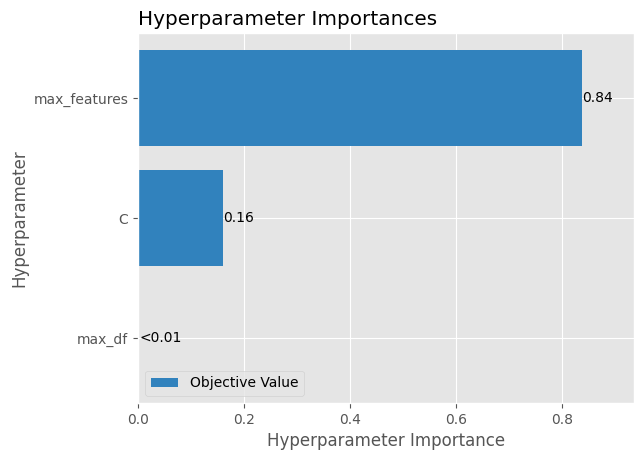

/tmp/ipython-input-1287638425.py:45: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  vis_mpl.plot_optimization_history(study_large)


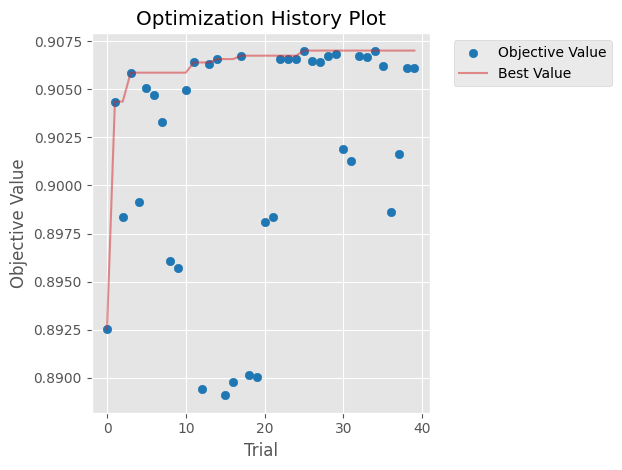

/tmp/ipython-input-1287638425.py:48: ExperimentalWarning: optuna.visualization.matplotlib._slice.plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  vis_mpl.plot_slice(study_large, params=["max_features"])


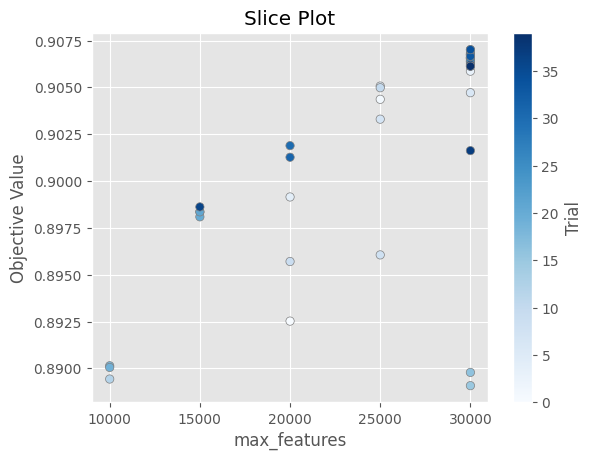

In [11]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import optuna
import optuna.visualization.matplotlib as vis_mpl
import matplotlib.pyplot as plt
import time

def create_objective_large_cached(y, tfidf_cache, cv=3):
    """Objective utilisant le cache TF-IDF pré-calculé."""
    def objective(trial):
        max_features = trial.suggest_categorical('max_features', MAX_FEATURES_VALUES)
        max_df = trial.suggest_categorical('max_df', MAX_DF_VALUES)
        C = trial.suggest_float('C', 0.1, 1.3, log=True)

        # Récupération de la matrice pré-calculée
        X_tfidf = tfidf_cache[(max_features, max_df)]['X_train']

        clf = LinearSVC(C=C, dual=True, max_iter=2000, random_state=42)

        # Mesure du temps
        t0 = time.perf_counter()
        score = cross_val_score(clf, X_tfidf, y, cv=cv, n_jobs=-1).mean()
        trial.set_user_attr("duration", time.perf_counter() - t0)

        return score

    return objective

def run_optuna_large_cached(y, tfidf_cache, n_trials=40, cv=3):
    study = optuna.create_study(direction='maximize')
    objective = create_objective_large_cached(y, tfidf_cache, cv)
    study.optimize(objective, n_trials=n_trials, n_jobs=-1, show_progress_bar=True)
    return study

# Lancement
study_large = run_optuna_large_cached(train_label, tfidf_cache, n_trials=40)

print(f"\n[LinearSVC] Meilleurs paramètres : {study_large.best_params}")
print(f"[LinearSVC] Meilleur score CV : {study_large.best_value:.4f}")

# Visualisations
vis_mpl.plot_param_importances(study_large)
plt.show()

vis_mpl.plot_optimization_history(study_large)
plt.show()

vis_mpl.plot_slice(study_large, params=["max_features"])
plt.show()

### **Quel paramètre influence le plus le temps d'execution ?**

In [12]:
from sklearn.ensemble import RandomForestRegressor
import polars as pl

def analyze_duration_importance(study, features, name):
    """Analyse l'importance des features sur le temps d'exécution."""
    df = pl.DataFrame([
        t.params | {'duration': t.user_attrs['duration']}
        for t in study.trials if t.state.name == "COMPLETE"
    ])

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(df[features], df["duration"])

    importance = sorted(
        zip(features, rf.feature_importances_.tolist()),
        key=lambda x: x[1],
        reverse=True
    )
    print(f"\n{name} - Importance des features sur le temps d'exécution:")
    for feat, imp in importance:
        print(f"  {feat}: {imp:.4f}")
    return importance

# Analyse pour les deux études
analyze_duration_importance(study_sgd, ["max_features", "max_df", "alpha"], "SGDClassifier")
analyze_duration_importance(study_large, ["max_features", "max_df", "C"], "LinearSVC")


SGDClassifier - Importance des features sur le temps d'exécution:
  alpha: 0.5923
  max_df: 0.2467
  max_features: 0.1610

LinearSVC - Importance des features sur le temps d'exécution:
  max_df: 0.4967
  C: 0.3564
  max_features: 0.1469


[('max_df', 0.49669720457916455),
 ('C', 0.3564053912362559),
 ('max_features', 0.14689740418457956)]

### **Résultats**

Le troisième graphique suggère que plus la dimensionalité des vecteurs TF-IDF est grande (plus l'hyperparamètre `max_features` est élevé), plus la performance est élevée